In [1]:
# First let's import the packages we will use in this project
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab
import matplotlib
# Set the plotting style to 'ggplot' for a clean, professional look with grid background
plt.style.use('ggplot')
from matplotlib.pyplot import figure

# Enable inline plotting so that plots appear directly in the notebook output
%matplotlib inline
# Set the default figure size to 12 inches wide by 8 inches tall for all plots
matplotlib.rcParams['figure.figsize'] = (12,8)

# Disable the SettingWithCopyWarning to avoid false positive warnings when modifying DataFrames
pd.options.mode.chained_assignment = None
# Configure pandas to display all rows in DataFrame outputs by default
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv("who_alcohol.csv")
df.head(10)

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode
0,Italy,ITA,2003,Both sexes,9.622988,7.965011,11.388622,3.423611,SA_0000001688
1,"Tanzania, United Republic of",TZA,2006,Both sexes,6.337646,4.767623,8.109324,3.341701,SA_0000001688
2,Cyprus,CYP,2017,Both sexes,6.117152,4.627244,7.798063,3.170819,SA_0000001688
3,Sierra Leone,SLE,2019,Both sexes,0.253228,0.100851,0.567434,0.466583,SA_0000001688
4,Philippines,PHL,2017,Both sexes,6.023875,4.681733,7.536645,2.854912,SA_0000001688
5,Qatar,QAT,2007,Both sexes,1.172084,0.612613,1.854674,1.242061,SA_0000001688
6,Pakistan,PAK,2018,Both sexes,0.104081,0.036438,0.340114,0.303676,SA_0000001688
7,Andorra,AND,2005,Both sexes,13.008124,11.013494,14.829454,3.815960,SA_0000001688
8,Slovenia,SVN,2000,Both sexes,12.477747,10.599043,14.375460,3.776417,SA_0000001688
9,Maldives,MDV,2009,Both sexes,1.963434,0.535407,3.335924,2.800517,SA_0000001688


As we can see, every country has one row for each year between 2000 and 2022 inclusive. 

Let's check for any missing values

In [3]:
# Calculate % of missing values per column. np.mean() on boolean Series (True=1, False=0) gives proportion of True values. Sums number of True (1) and divides by total count

for col in df.columns:
    pct = np.mean(df[col].isnull())
    print(f"{pct * 100}%")


0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%


There are no missing values within the data. 

Let's convert alcohol_liters_per_capita into a more readable and easily understood form.

Let's convert it to units_per_capita_week (UK Units = 10ml Pure alcohol)
Let's also add a percentage of the UK low-risk guideline consumed per week (14 units)

In [4]:
df["units_per_capita_week"] = round(df["alcohol_liters_per_capita"] * 100 / 52, ndigits=1)
df["perc_uk_guideline"] = round(df["units_per_capita_week"] / 14 * 100, ndigits=1)
df.sort_values(by="units_per_capita_week", ascending=False).head()

,country,iso3,year,sex,alcohol_liters_per_capita,lower_ci,upper_ci,ci_width,IndicatorCode,units_per_capita_week,perc_uk_guideline
1027,Romania,ROU,2002,Both sexes,19.497715,16.902455,22.251088,5.348633,SA_0000001688,37.5,267.9
3019,Romania,ROU,2003,Both sexes,19.389771,16.643855,22.116943,5.473088,SA_0000001688,37.3,266.4
803,Romania,ROU,2000,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1856,Romania,ROU,2001,Both sexes,18.993118,16.298520,21.785253,5.486733,SA_0000001688,36.5,260.7
1768,Romania,ROU,2004,Both sexes,18.639676,15.787315,21.476058,5.688743,SA_0000001688,35.8,255.7


Let's begin analysing.

### Question 1: Are global alcohol consumption levels trending upward or downward overall?

In [5]:
#finds average consumption per person per year
yearly = df.groupby("year")["alcohol_liters_per_capita"].aggregate('mean')
#convert year index into an explicit column
yearly = yearly.reset_index()


Text(0, 0.5, 'Total Liters of Alcohol (Per Capita Sum)')

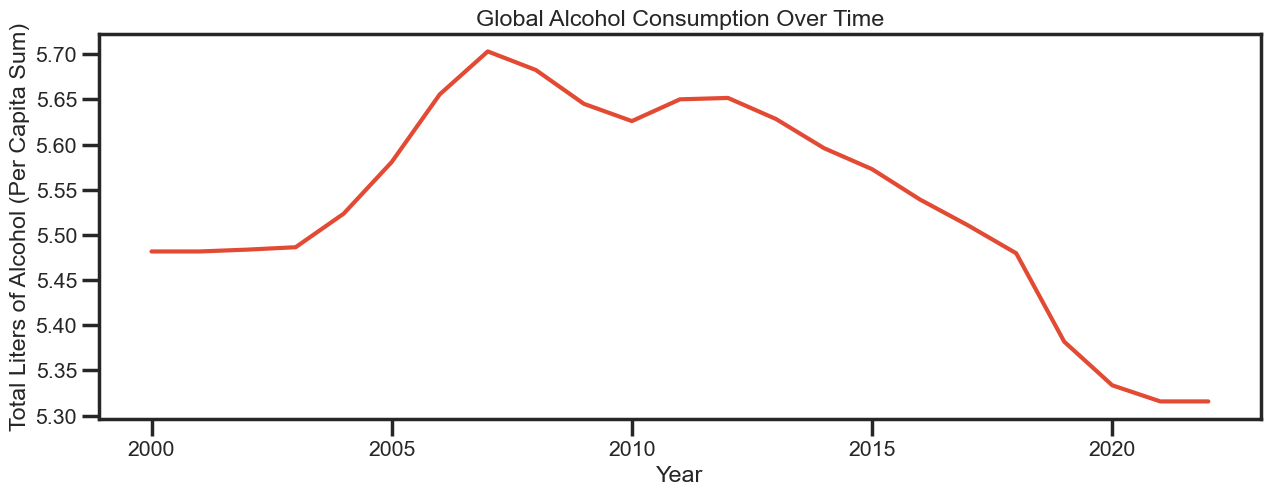

In [6]:
#sets background
sns.set_style("ticks")
#sets size of labels, font etc
# poster, paper, notebook, talk
sns.set_context('poster', font_scale = 0.7)
plt.figure(figsize=(15, 5))

sns.lineplot(
    data=yearly,
    x = "year",
    y = "alcohol_liters_per_capita"
)

plt.title("Global Alcohol Consumption Over Time")
plt.xlabel("Year")
plt.ylabel("Total Liters of Alcohol (Per Capita Sum)")

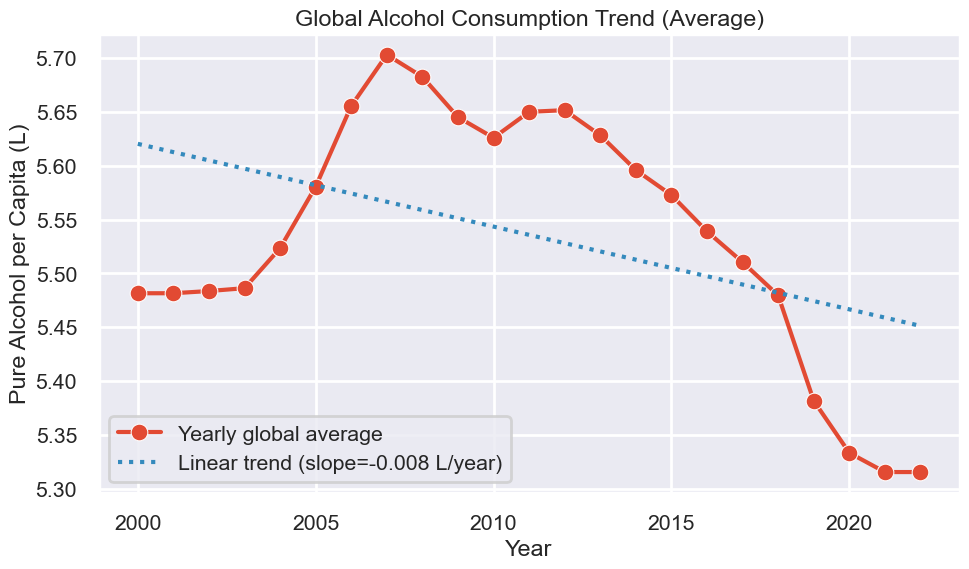

In [7]:
x = yearly["year"]
y = yearly["alcohol_liters_per_capita"]


#np.polyfit() finds best-fitting polynomial curve through data points: y ≈ m*x + c
#degree=1 means "a straight line"
m, c = np.polyfit(x, y, 1)

# This creates the function y = m*x + c
f = np.poly1d([m, c]) #takes a list of coefficients in descending order of polynomial degree
y_best_fit = f(x) # computes y values for all x values


sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Plot the actual yearly global averages as a line chart
sns.lineplot(
    data=yearly,
    x=x,
    y=y,
    marker="o", # show dots at each year
    label="Yearly global average"
)

# Overlay the regression line
plt.plot(
    x,
    y_best_fit,
    linestyle=":",
    label=f"Linear trend (slope={m:.3f} L/year)"
)

# Add titles and axis labels so the plot is self-explanatory (portfolio essential)
plt.title("Global Alcohol Consumption Trend (Average)")
plt.xlabel("Year")
plt.ylabel("Pure Alcohol per Capita (L)")
plt.legend()
plt.tight_layout()


We can see that Global alcohol consumption levels have been decreasing since 2012 worldwide. 
* The constant decrease since 2012 may be due to the rise of health and safety information regarding alcohol consumption
* 2020-2022 have all time lows, most likely due do the COVID-19 pandemic.



### Question 2: Which countries have experienced the largest increases or decreases in alcohol consumption since 2000?


In [8]:
'''
find the countries with the most change in alcohol consumption since 2000. 
is this as simple as just finding the difference between the alcohol consumption from 2000 to 2022. is there a more universal way to factor in every single year as well?
method 1: compare the alcohol consumption in 2000 for that country with the one in 2022 and take the 10 largest differences
method 2: find percentage change between 2022 and 2000. same as method above but normalises starting values. 
'''


'\nfind the countries with the most change in alcohol consumption since 2000. \nis this as simple as just finding the difference between the alcohol consumption from 2000 to 2022. is there a more universal way to factor in every single year as well?\nmethod 1: compare the alcohol consumption in 2000 for that country with the one in 2022 and take the 10 largest differences\nmethod 2: find percentage change between 2022 and 2000. same as method above but normalises starting values. \n'

In [9]:
'''
calculate percentage change of alcohol consumption per country, then list the top 10 increases and decreases in a table format
Then create a stacked line chart that plots alcohol consumption by percentage increase / decrease from that country's original consumption in 2000
2 separate charts, one for increased and one for decreased 
'''

"\ncalculate percentage change of alcohol consumption per country, then list the top 10 increases and decreases in a table format\nThen create a stacked line chart that plots alcohol consumption by percentage increase / decrease from that country's original consumption in 2000\n2 separate charts, one for increased and one for decreased \n"

In [13]:
# Separate 2000 and 2022 data
df_2000 = df[df["year"] == 2000].rename(columns={"alcohol_liters_per_capita": "consumption_2000"})
df_2022 = df[df["year"] == 2022].rename(columns={"alcohol_liters_per_capita": "consumption_2022"})

# Merge on country
merged_2000_2022 = df_2000.merge(df_2022, on="country")
merged_2000_2022["per_change"] = round((merged_2000_2022["consumption_2022"] - merged_2000_2022["consumption_2000"]) / merged_2000_2022["consumption_2000"] * 100)

#remove any country where the starting and ending consumption is less than 1. Removes most widely religious countries where alcohol isn't really consumed at all
merged_2000_2022 = merged_2000_2022[(merged_2000_2022["consumption_2000"] >= 1) & (merged_2000_2022["consumption_2022"] >= 1)]

In [ ]:
#10 biggest increases
(
    merged_2000_2022
    .sort_values(by="per_change", ascending=False)
    [["country", "consumption_2000", "consumption_2022", "units_per_capita_week_x", "units_per_capita_week_y", "per_change"]]
    .head(10)
 )

,country,consumption_2000,consumption_2022,units_per_capita_week_x,units_per_capita_week_y,per_change
20,Mongolia,2.760842,7.735525,5.3,14.9,180.0
177,Viet Nam,4.046239,10.715408,7.8,20.6,165.0
14,India,1.938444,4.544854,3.7,8.7,134.0
66,Congo,2.718459,6.351449,5.2,12.2,134.0
50,Ethiopia,1.445410,3.140352,2.8,6.0,117.0
17,Nepal,1.729294,3.733279,3.3,7.2,116.0
29,Mozambique,1.117681,1.911122,2.1,3.7,71.0
151,Azerbaijan,1.459880,2.321017,2.8,4.5,59.0
76,Sri Lanka,1.707510,2.704348,3.3,5.2,58.0
167,Côte d'Ivoire,2.864658,4.492422,5.5,8.6,57.0


In [15]:
#10 biggest decreases
(
    merged_2000_2022
    .sort_values(by="per_change", ascending=True)
    [["country", "consumption_2000", "consumption_2022", "units_per_capita_week_x", "units_per_capita_week_y", "per_change"]]
    .head(10)
 )

,country,consumption_2000,consumption_2022,units_per_capita_week_x,units_per_capita_week_y,per_change
133,"Venezuela, Bolivarian Republic of",8.240533,2.339490,15.8,4.5,-72.0
114,Burkina Faso,17.475384,7.457268,33.6,14.3,-57.0
43,Bahrain,2.725937,1.660289,5.2,3.2,-39.0
115,Niue,5.381357,3.281498,10.3,6.3,-39.0
96,"Micronesia, Federated States of",3.173740,1.956769,6.1,3.8,-38.0
31,Ecuador,4.233465,2.691321,8.1,5.2,-36.0
176,Samoa,4.366934,2.864228,8.4,5.5,-34.0
92,Angola,5.750129,3.981507,11.1,7.7,-31.0
142,Kyrgyzstan,5.702338,3.919740,11.0,7.5,-31.0
143,Montenegro,11.477631,8.014333,22.1,15.4,-30.0


Many countries will not be considered in order to make this analysis meaningful.
For instance:
* Yemen ranked first in largest increase. Alcohol is largely illegal in Yemen since over 99% of Yemen's population is Muslim
* 91-97% of Sudan is Sunni Muslim
* 97-99% of Libya is Muslim